<a href="https://colab.research.google.com/github/hitesh777/coin-classification/blob/main/coin_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

%matplotlib inline

In [5]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/JPEGImages.zip","/content/drive/MyDrive/coin_data")

In [4]:
input_path = Path('/content/drive/MyDrive/coin_data/JPEGImages')
im_size = 320

In [5]:
image_files = list(input_path.glob('*.jpg'))

In [7]:
def read_file(fname):
    # Read image
    im = Image.open(fname)

    # Resize
    im.thumbnail((im_size, im_size))

    # Convert to numpy array
    im_array = np.asarray(im)

    # Get target
    target = int(fname.stem.split('_')[0])

    return im_array, target

In [8]:
images = []
targets = []

for image_file in tqdm_notebook(image_files):
    image, target = read_file(image_file)
    
    images.append(image)
    targets.append(target)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [9]:
X = (np.array(images).astype(np.float32) / 127.5) - 1
y_cls = np.array(targets)

In [10]:
X.shape, y_cls.shape

((3056, 240, 320, 3), (3056,))

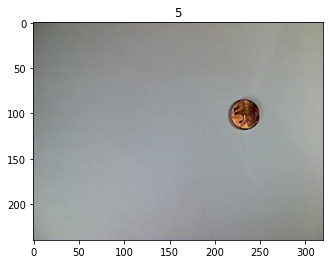

In [11]:
i = 555
plt.imshow(np.uint8((X[i] + 1) * 127.5))
plt.title(str(y_cls[i]));

In [12]:
coins_ids = {
    5: 0,
    10: 1,
    25: 2,
    50: 3,
    100: 4
}

ids_coins = [5, 10, 25, 50, 100]

y = np.array([coins_ids[coin] for coin in y_cls])

In [13]:
X_train, X_valid, y_train, y_valid, fname_train, fname_valid = train_test_split(
    X, y, image_files, test_size=0.2, random_state=42)

In [14]:
im_width = X.shape[2]
im_height = X.shape[1]

im_width, im_height

(320, 240)

# Keras

In [52]:
from keras.layers import Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D, Dense
from keras.models import Sequential
from keras.optimizers import Adam,Adamax
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [53]:
model = Sequential()

# CNN network
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(im_height, im_width, 3)) )
model.add( MaxPool2D(2) )

model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(128, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(256, 3, activation='relu', padding='same') )
model.add( Conv2D(256, 3, activation='relu', padding='same') )
model.add( Conv2D(256, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )
model.add( Conv2D(256, 3, activation='relu', padding='same') )


# Transition between CNN and MLP
model.add( GlobalAvgPool2D() )

# MLP network
model.add( Dense(256, activation='relu') )

model.add( Dense(5, activation='softmax') )

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 240, 320, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 160, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 80, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 40, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 40, 128)      

In [55]:
optim = Adamax(learning_rate=1e-3)
model.compile(optim, 'sparse_categorical_crossentropy', metrics=['acc'])

In [56]:
callbacks = [
    ReduceLROnPlateau(patience=5, factor=0.1, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=12)
]

history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_valid, y_valid), batch_size=32,
                   callbacks=callbacks)

Epoch 1/2000
77/77 [==============================] - 7s 75ms/step - loss: 1.6148 - acc: 0.2150 - val_loss: 1.6079 - val_acc: 0.1797
INFO:tensorflow:Assets written to: best.model/assets
Epoch 2/2000
77/77 [==============================] - 5s 69ms/step - loss: 1.5795 - acc: 0.2329 - val_loss: 1.2718 - val_acc: 0.4641
INFO:tensorflow:Assets written to: best.model/assets
Epoch 3/2000
77/77 [==============================] - 5s 68ms/step - loss: 1.1644 - acc: 0.5029 - val_loss: 0.9156 - val_acc: 0.5539
INFO:tensorflow:Assets written to: best.model/assets
Epoch 4/2000
77/77 [==============================] - 5s 68ms/step - loss: 0.8569 - acc: 0.6477 - val_loss: 0.7676 - val_acc: 0.7337
INFO:tensorflow:Assets written to: best.model/assets
Epoch 5/2000
77/77 [==============================] - 5s 68ms/step - loss: 0.6421 - acc: 0.7366 - val_loss: 0.6348 - val_acc: 0.7582
INFO:tensorflow:Assets written to: best.model/assets
Epoch 6/2000
77/77 [==============================] - 5s 66ms/step - l

In [57]:
df_history = pd.DataFrame(history.history)
df_history

,loss,acc,val_loss,val_acc,lr
0,1.610014,0.204583,1.607874,0.179739,0.001000
1,1.539356,0.283142,1.271776,0.464052,0.001000
2,1.076908,0.553191,0.915580,0.553922,0.001000
3,0.802899,0.662439,0.767646,0.733660,0.001000
4,0.629008,0.759002,0.634780,0.758170,0.001000
5,0.446644,0.835516,0.575646,0.764706,0.001000
6,0.368277,0.869476,0.260650,0.926471,0.001000
7,0.294214,0.898936,0.215105,0.934641,0.001000
8,0.244913,0.908756,0.171734,0.949346,0.001000
9,0.139408,0.954992,0.131461,0.950980,0.001000


(0.9, 1.0)

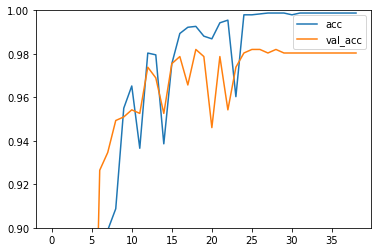

In [58]:
ax = df_history[['acc', 'val_acc']].plot()
ax.set_ylim(0.9, 1)

In [59]:
df_history['val_acc'].max()

0.9820261597633362

In [60]:
model.load_weights('best.model')

In [61]:
model.evaluate(X_valid, y_valid)

20/20 [==============================] - 1s 30ms/step - loss: 0.0698 - acc: 0.9820


[0.06982970982789993, 0.9820261597633362]

# Evaluate results

In [62]:
y_pred = model.predict(X_valid)

In [63]:
y_pred_cls = y_pred.argmax(1)

In [64]:
errors = np.where(y_pred_cls != y_valid)[0]
errors

array([ 16, 100, 110, 133, 198, 237, 266, 268, 365, 451, 515])

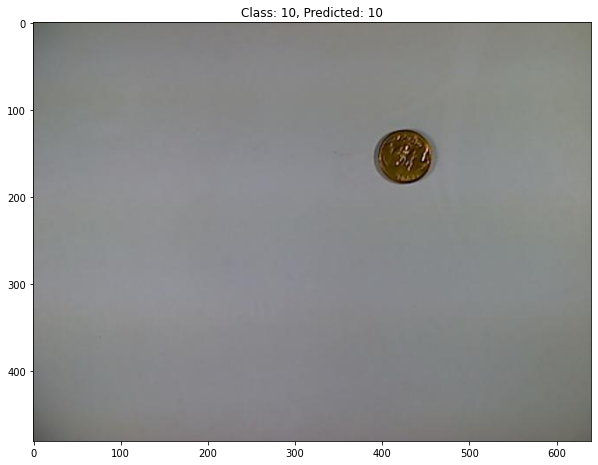

In [65]:
i = 289
plt.figure(figsize=(10, 10))
im = Image.open(fname_valid[i])
plt.imshow(np.uint8(im), interpolation='bilinear')
plt.title('Class: {}, Predicted: {}'.format(ids_coins[y_valid[i]], ids_coins[np.argmax(y_pred[i])]));